In [1]:
from src.Distributions import *
from collections import Counter
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import matplotlib.lines as mlines
plt.style.use('properties.mplstyle')

In [2]:
alpha_a_v = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
alpha_g_f = 2.0

alpha_a_f = 2.0
alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0]

N = 10**5
dim = [1,2,3,4]

In [10]:
import os
import glob
import pandas as pd
import numpy as np
import re
from multiprocessing import Pool

def process_distance_file(args):
    idx, file = args
    try:
        degrees = np.random.randint(0, 10, size=10**5)  # Simulação
        return idx, degrees, os.path.basename(file)
    except Exception as e:
        print(f"Erro ao processar {file}: {e}")
        return None

def process_all_degree_files(base_path):
    """Percorre toda a estrutura de pastas e processa os arquivos de grau."""
    pattern = os.path.join(base_path, "N_*", "dim_*", "alpha_a_*_alpha_g*", "gml")
    all_gml_folders = sorted(glob.glob(pattern))

    if not all_gml_folders:
        print("Nenhuma pasta com arquivos .gml encontrada.")
        return

    for gml_folder in all_gml_folders:
        output_dir = os.path.dirname(gml_folder)
        path_parts = output_dir.split(os.sep)

        try:
            N = int(path_parts[-3].split("_")[1])
            dim = int(path_parts[-2].split("_")[1])

            # 🔍 Corrigir extração de alpha_a e alpha_g com regex
            match = re.match(r'alpha_a_([0-9.]+)_alpha_g_([0-9.]+)', path_parts[-1])
            if not match:
                raise ValueError(f"Formato inesperado de pasta: {path_parts[-1]}")
            alpha_a = float(match.group(1))
            alpha_g = float(match.group(2))

            # Garantir 2 casas decimais
            alpha_a_str = f"{alpha_a:.2f}"
            alpha_g_str = f"{alpha_g:.2f}"

        except Exception as e:
            print(f"Erro ao extrair parâmetros da pasta: {output_dir} — {e}")
            continue

        print(f"Processando: N={N}, dim={dim}, alpha_a={alpha_a_str}, alpha_g={alpha_g_str}")

        # Arquivos da pasta
        all_files = sorted(glob.glob(os.path.join(gml_folder, "*.gml.gz")))

        if not all_files:
            print(f"Pasta vazia: {gml_folder}")
            continue

        n_files = len(all_files)
        n_lines = 10**5

        # Caminhos dos arquivos de saída
        degree_npy_path = os.path.join(base_path, f"N_{N}/dim_{dim}/alpha_a_{alpha_a_str}_alpha_g_{alpha_g_str}/degree.npy")
        filenames_csv_path = os.path.join(base_path, f"N_{N}/dim_{dim}/alpha_a_{alpha_a_str}_alpha_g_{alpha_g_str}/filenames_degree.csv")

        # Verificar arquivos já processados
        if os.path.exists(filenames_csv_path):
            df_existing = pd.read_csv(filenames_csv_path)
            processed_files = set(df_existing["filenames"].tolist())
        else:
            df_existing = pd.DataFrame(columns=["filenames"])
            processed_files = set()

        # Filtrar os não processados
        new_files = [file for file in all_files if os.path.basename(file) not in processed_files]

        if not new_files:
            print("Todos os arquivos já foram processados. Pulando...")
            continue

        print(f"  → Processando {len(new_files)} novos arquivos...")

        with Pool() as pool:
            results = pool.map(process_distance_file, enumerate(new_files))

        results = [res for res in results if res is not None]

        new_filenames = []
        new_data = np.empty((n_lines, len(results)), dtype=np.int32)

        for i, (idx, degrees, filename) in enumerate(results):
            new_data[:, i] = degrees
            new_filenames.append(filename)

        # Concatenar com dados existentes (se houver)
        if os.path.exists(degree_npy_path):
            existing_data = np.load(degree_npy_path)
            updated_data = np.hstack((existing_data, new_data))
        else:
            updated_data = new_data

        np.save(degree_npy_path, updated_data)

        # Atualizar CSV
        df_new = pd.DataFrame({"filenames": new_filenames})
        df_updated = pd.concat([df_existing, df_new], ignore_index=True)
        df_updated.to_csv(filenames_csv_path, index=False)

        print(f"  ✔ Dados salvos em: {os.path.dirname(degree_npy_path)}\n")

# Exemplo de uso:
process_all_degree_files("../../data/")


Processando: N=5000, dim=1, alpha_a=3.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_1/alpha_a_3.00_alpha_g_2.00/gml
Processando: N=5000, dim=2, alpha_a=10.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_2/alpha_a_10.00_alpha_g_2.00/gml
Processando: N=5000, dim=2, alpha_a=7.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_2/alpha_a_7.00_alpha_g_2.00/gml
Processando: N=5000, dim=2, alpha_a=8.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_2/alpha_a_8.00_alpha_g_2.00/gml
Processando: N=5000, dim=3, alpha_a=10.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_3/alpha_a_10.00_alpha_g_2.00/gml
Processando: N=5000, dim=3, alpha_a=12.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_3/alpha_a_12.00_alpha_g_2.00/gml
Processando: N=5000, dim=3, alpha_a=14.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_3/alpha_a_14.00_alpha_g_2.00/gml
Processando: N=5000, dim=3, alpha_a=15.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_3/alpha_a_15.00_alpha_g_2.00/gml
Processando: N

In [3]:
# Generate .npy with all degree and distances values from gml.gz files
for d in dim:
    for aa in alpha_a_v:
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        degree_file(N, d, aa, alpha_g_f)
        distance_file(N, d, aa, alpha_g_f)
    print("-----------------")
    for ag in alpha_g_v:
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        degree_file(N, d, alpha_a_f, ag)
        distance_file(N, d, alpha_a_f, ag)

N = 100000, dim = 1, alpha_a = 0.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 3.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 4.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 5.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 6.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 7.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 8.0, alpha_g = 2.0
Folder empty
Folder empty
-----------------
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 1.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 3.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 4.0
Folder empty
Folder 

In [88]:
# Delete all gml files after processing distances and degrees
folder = "../../data"
delete_files_in_gml_folders(folder)

Removendo arquivos dentro da pasta: ../../data/N_5000/dim_1/alpha_a_3.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_3/alpha_a_14.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_3/alpha_a_15.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_3/alpha_a_10.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_3/alpha_a_12.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_14.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_15.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_10.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_13.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_12.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_2/alpha_a_8.0_alpha_g_2.0/gml
Removendo arquivos dent

In [89]:
# Generate .npy with all degree values from gml.gz files
bin_count = 80
for d in dim:
    for aa in alpha_a_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="degree")

        # Generate linear binning to degree
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="degree")
    
    print("-----------------")
    for ag in alpha_g_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="degree")

        # Generate linear binning to degree
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="degree")

N = 100000, dim = 1, alpha_a = 0.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alp

In [3]:
k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [4]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    
    k_1d_g[i], pk_1d_g[i] = df_1d["k"], df_1d["pk"]
    k_2d_g[i], pk_2d_g[i] = df_2d["k"], df_2d["pk"]
    k_3d_g[i], pk_3d_g[i] = df_3d["k"], df_3d["pk"]
    k_4d_g[i], pk_4d_g[i] = df_4d["k"], df_4d["pk"]
alpha_a_v = [0.0, 1.0, 2.0, 4.0, 6.0, 8.0]
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["k"], df_1d["pk"]
        k_2d_a[i], pk_2d_a[i] = df_2d["k"], df_2d["pk"]
        k_3d_a[i], pk_3d_a[i] = df_3d["k"], df_3d["pk"]
        k_4d_a[i], pk_4d_a[i] = df_4d["k"], df_4d["pk"]

In [5]:
k_1d_g_log, pk_1d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g_log, pk_2d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g_log, pk_3d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g_log, pk_4d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a_log, pk_1d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a_log, pk_2d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a_log, pk_3d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a_log, pk_4d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [6]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    
    k_1d_g_log[i], pk_1d_g_log[i] = df_1d["k"], df_1d["pk"]
    k_2d_g_log[i], pk_2d_g_log[i] = df_2d["k"], df_2d["pk"]
    k_3d_g_log[i], pk_3d_g_log[i] = df_3d["k"], df_3d["pk"]
    k_4d_g_log[i], pk_4d_g_log[i] = df_4d["k"], df_4d["pk"]

for i in range(len(alpha_a_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_a_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_a_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    
    k_1d_a_log[i], pk_1d_a_log[i] = df_1d["k"], df_1d["pk"]
    k_2d_a_log[i], pk_2d_a_log[i] = df_2d["k"], df_2d["pk"]
    k_3d_a_log[i], pk_3d_a_log[i] = df_3d["k"], df_3d["pk"]
    k_4d_a_log[i], pk_4d_a_log[i] = df_4d["k"], df_4d["pk"]


In [7]:
# # The adjustment will be done only in the pk region in the interval [10⁻⁶, 1], filtering pk values ​​in this interval
# k_filtered = []
# pk_filtered = []
# threshold = 1e-6  # Definição do limite mínimo

# for k_sublist, pk_sublist in zip(k_1d_g, pk_1d_g):
#     # Filtra os valores mantendo a relação 1:1
#     filtered_pairs = [(ki, pki) for ki, pki in zip(k_sublist, pk_sublist) if pki >= threshold]
    
#     # Separa novamente em listas individuais
#     if filtered_pairs:
#         k_filtered.append([ki for ki, pki in filtered_pairs])
#         pk_filtered.append([pki for ki, pki in filtered_pairs])
#     else:
#         k_filtered.append([])  # Mantém a estrutura original
#         pk_filtered.append([])

#print(q(alpha_a_v[2],1))
#for v in range(len(alpha_g_v)):
v = 0
k, pk = k_filtered[v], pk_filtered[v]

#q,err_q, b, err_b = bootstrap_q_exp(k, pk, n_bootstrap=10000)

#Q, B = optimize_q_exp(k, pk, q_initial=q(2.0,1), b_initial=eta(2.0,1), delta_q=0.01, delta_b=0.01)

#print(Q, B)
markersize = 9
plt.plot(k, pk,'o', ms=markersize)
plt.plot(k, q_exp(k, q,b))
plt.xscale("log")
plt.yscale("log")
plt.ylim([10**(-6),1])
#plt.savefig("result_new.pdf")
plt.show()

NameError: name 'k_filtered' is not defined

In [101]:
q_1d, err_1d_q, b_1d, err_1d_b = bootstrap_q_exp(k_1d_g_log, pk_1d_g_log, dim = 1, alpha_a=2.0, n_bootstrap=10000)
q_2d, err_2d_q ,b_2d, err_2d_b = bootstrap_q_exp(k_2d_g_log, pk_2d_g_log, dim = 2, alpha_a=2.0, n_bootstrap=10000)
q_3d, err_3d_q, b_3d, err_3d_b = bootstrap_q_exp(k_3d_g_log, pk_3d_g_log, dim = 3, alpha_a=2.0, n_bootstrap=10000)
q_4d, err_4d_q, b_4d, err_4d_b = bootstrap_q_exp(k_4d_g_log, pk_4d_g_log, dim = 4, alpha_a=2.0, n_bootstrap=10000)

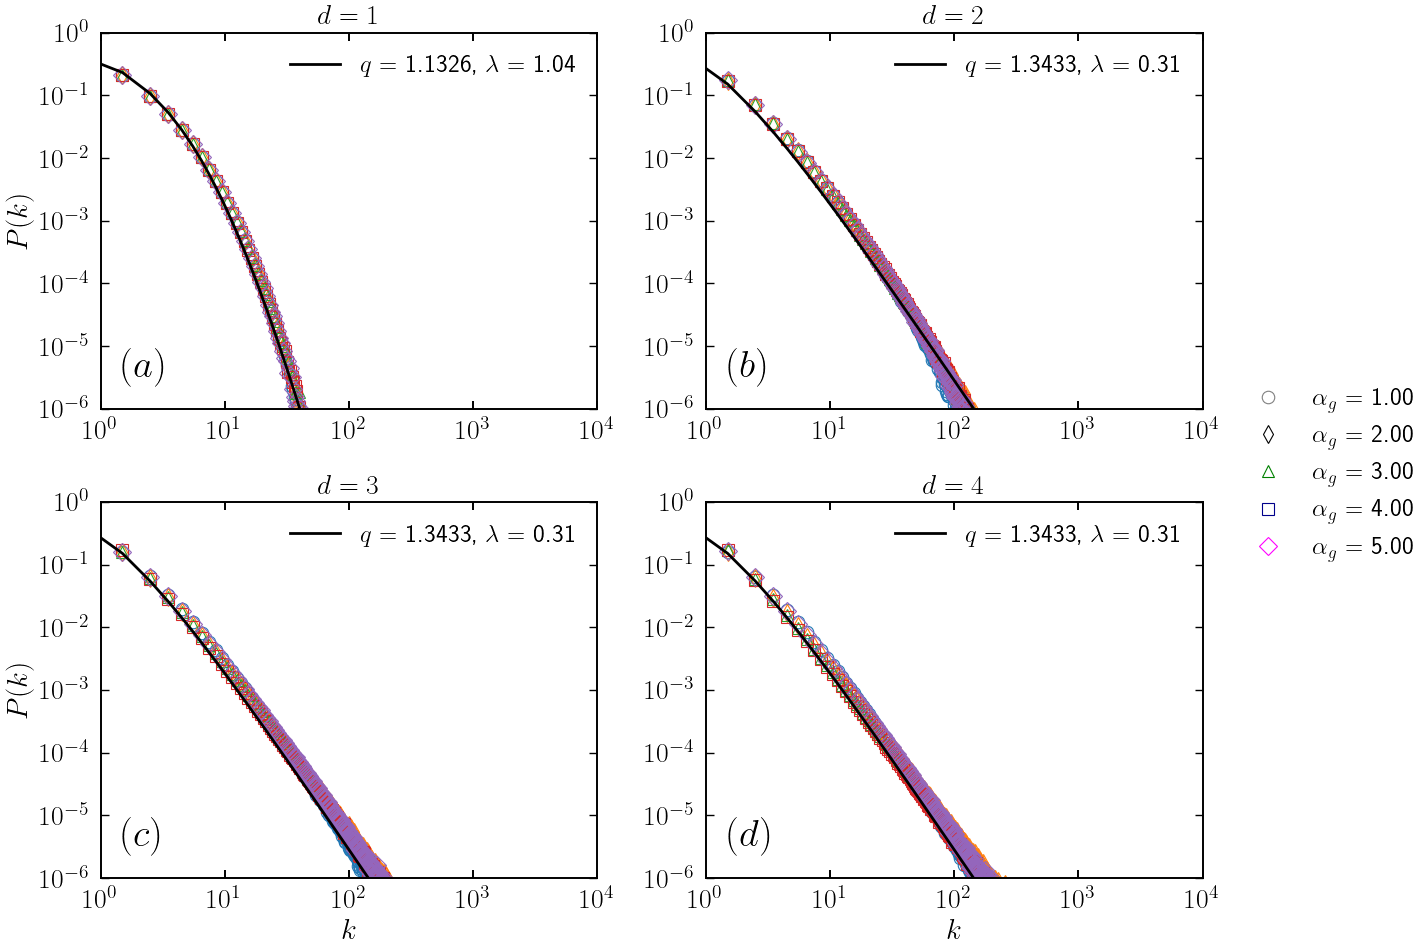

In [ ]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]

labels_1 = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]

markers = ["o","d","^","s","D"]
dim = [1,2,3,4]
titles = [f"$d = {d}$" for d in dim]
labels_global = [rf"$\alpha_g$ = {alpha_g_v[i]:.2f}" for i in range(len(alpha_g_v))]


fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
    # Plot data
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i],markers[i])
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i],markers[i])
    ax[1, 0].plot(k_3d_g[i], pk_3d_g[i],markers[i])
    ax[1, 1].plot(k_4d_g[i], pk_4d_g[i],markers[i])
 
label_1d, label_2d = f'$q$ = {q_1d:.4f}, $\\lambda$ = {b_1d:.2f}', f'$q$ = {q_2d:.4f}, $\\lambda$ = {b_2d:.2f}'
label_3d, label_4d = f'$q$ = {q_3d:.4f}, $\\lambda$ = {b_3d:.2f}', f'$q$ = {q_4d:.4f}, $\\lambda$ = {b_4d:.2f}'

ax[0, 0].plot(k_1d_g[1],q_exp(k_1d_g[1], q_1d, b_1d), label = label_1d, color="k", linewidth = 2.0)
ax[0, 1].plot(k_2d_g[1],q_exp(k_2d_g[1], q_2d, b_2d), label = label_2d, color="k", linewidth = 2.0)
ax[1, 0].plot(k_3d_g[1],q_exp(k_3d_g[1], q_3d, b_3d), label = label_3d, color="k", linewidth = 2.0)
ax[1, 1].plot(k_4d_g[1],q_exp(k_4d_g[1], q_4d, b_4d), label = label_4d, color="k", linewidth = 2.0)


ax[0, 0].text(1.5, 10**(-5.5), "$(a)$", style="normal" ,fontsize=28)
ax[0, 1].text(1.5, 10**(-5.5), "$(b)$", style="normal" ,fontsize=28)
ax[1, 0].text(1.5, 10**(-5.5), "$(c)$", style="normal" ,fontsize=28)
ax[1, 1].text(1.5, 10**(-5.5), "$(d)$", style="normal" ,fontsize=28)


# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_g_v))]

# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1,10**4])
        ax[i, j].set_ylim([10**(-6),1])
        ax[i, j].set_title(titles[i*2+j], fontsize=20)
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        ax[i, j].legend(prop={"size":18},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(k)$",size=21)
        ax[1, j].set_xlabel(r"$k$",size=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        
        
#fig.suptitle(r'Distribuição de graus para múltiplos $\alpha_g$', fontsize=30)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/degree_alpha_g.pdf",dpi=300)
plt.show()

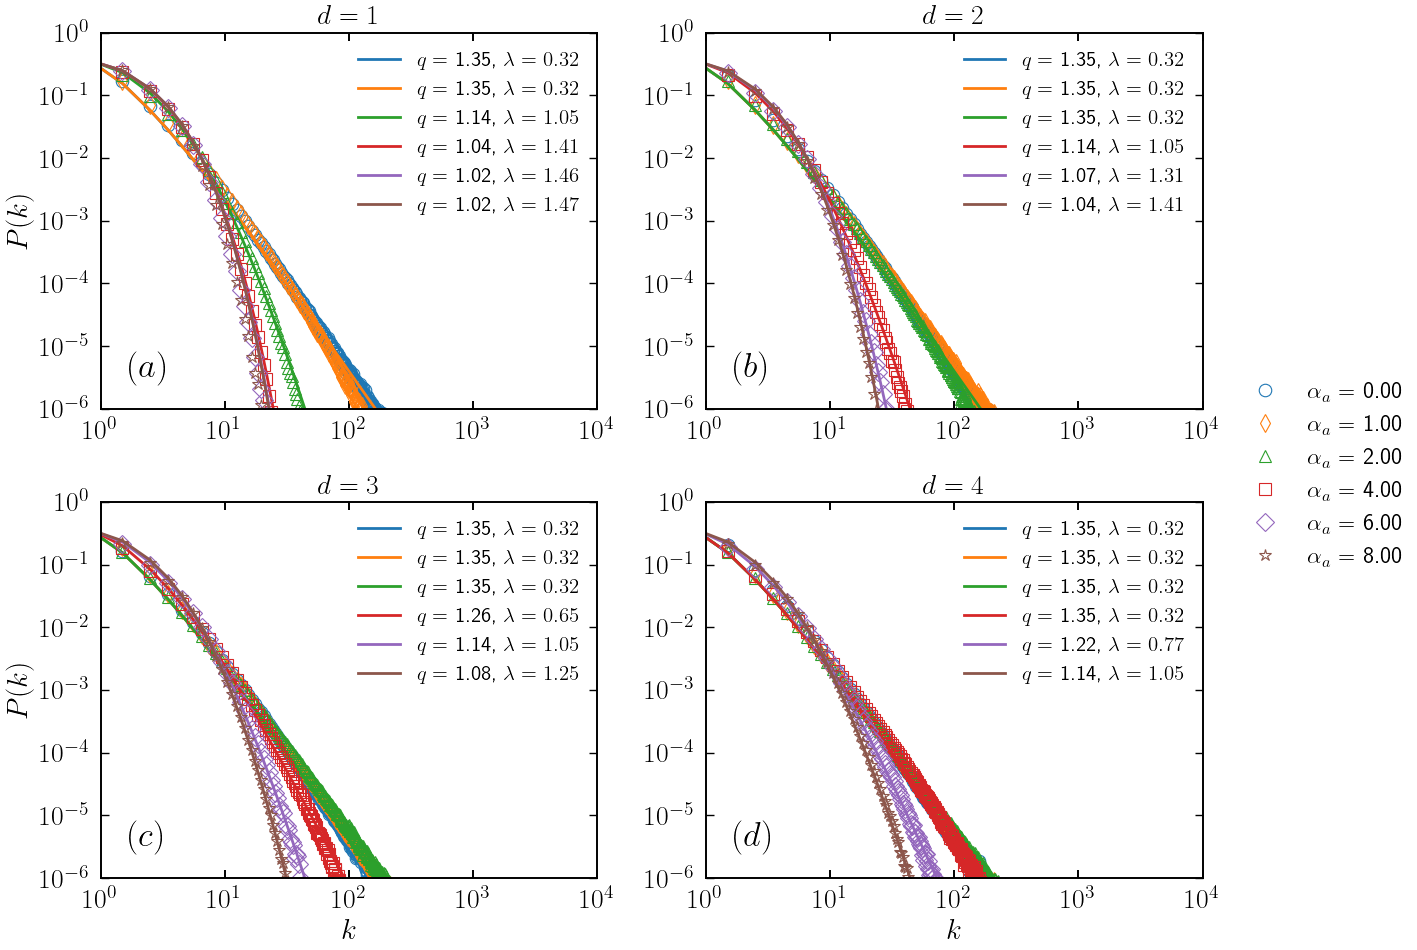

In [131]:
Q_1d, B_1d = [], []
Q_2d, B_2d = [], []
Q_3d, B_3d = [], []
Q_4d, B_4d = [], []

for i in range(len(alpha_a_v)):
    q_1d, b_1d = optimize_q_exp(k_1d_a_log[i], k_1d_a_log[i], q_initial=q(alpha_a_v[i], 1), b_initial=eta(alpha_a_v[i], 1), delta_q=0.01, delta_b=0.01)
    q_2d, b_2d = optimize_q_exp(k_2d_a_log[i], k_2d_a_log[i], q_initial=q(alpha_a_v[i], 2), b_initial=eta(alpha_a_v[i], 2), delta_q=0.01, delta_b=0.01)
    q_3d, b_3d = optimize_q_exp(k_3d_a_log[i], k_3d_a_log[i], q_initial=q(alpha_a_v[i], 3), b_initial=eta(alpha_a_v[i], 3), delta_q=0.01, delta_b=0.01)
    q_4d, b_4d = optimize_q_exp(k_4d_a_log[i], k_4d_a_log[i], q_initial=q(alpha_a_v[i], 4), b_initial=eta(alpha_a_v[i], 4), delta_q=0.01, delta_b=0.01)

    Q_1d.append(float(q_1d))
    Q_2d.append(float(q_2d))
    Q_3d.append(float(q_3d))
    Q_4d.append(float(q_4d))
    
    B_1d.append(float(b_1d))
    B_2d.append(float(b_2d))
    B_3d.append(float(b_3d))
    B_4d.append(float(b_4d))

markers = ["o","d","^","s","D","*","H","p","P"]

labels_global = [rf"$\alpha_a$ = {alpha_a_v[i]:.2f}" for i in range(len(alpha_a_v))]
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markersize = 9
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_a_v)):    
    qq_1d, bb_1d = optimize_q_exp(k_1d_a_log[i], k_1d_a_log[i], q_initial=Q_1d[i], b_initial=B_1d[i], delta_q=0.01, delta_b=0.01)
    qq_2d, bb_2d = optimize_q_exp(k_2d_a_log[i], k_2d_a_log[i], q_initial=Q_2d[i], b_initial=B_2d[i], delta_q=0.01, delta_b=0.01)
    qq_3d, bb_3d = optimize_q_exp(k_3d_a_log[i], k_3d_a_log[i], q_initial=Q_3d[i], b_initial=B_3d[i], delta_q=0.01, delta_b=0.01)
    qq_4d, bb_4d = optimize_q_exp(k_4d_a_log[i], k_4d_a_log[i], q_initial=Q_4d[i], b_initial=B_4d[i], delta_q=0.01, delta_b=0.01)
    
    # Plot data
    ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i])
    ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i])
    ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i])
    ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i])
    
    # ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    
    ax[0, 0].plot(k_1d_a[i], q_exp(k_1d_a[i], qq_1d, bb_1d), color=color[i],label=rf'$q =$ {qq_1d:.2f}, $\lambda = {bb_1d:.2f}$', linewidth=2.0)
    ax[0, 1].plot(k_2d_a[i], q_exp(k_2d_a[i], qq_2d, bb_2d), color=color[i],label=rf'$q =$ {qq_2d:.2f}, $\lambda = {bb_2d:.2f}$', linewidth=2.0)
    ax[1, 0].plot(k_3d_a[i], q_exp(k_3d_a[i], qq_3d, bb_3d), color=color[i],label=rf'$q =$ {qq_3d:.2f}, $\lambda = {bb_3d:.2f}$', linewidth=2.0)
    ax[1, 1].plot(k_4d_a[i], q_exp(k_4d_a[i], qq_4d, bb_4d), color=color[i],label=rf'$q =$ {qq_4d:.2f}, $\lambda = {bb_4d:.2f}$', linewidth=2.0)

        
# ax[0, 0].plot(k_1d_a[0],q_exp(k_1d_a[0], Q_1d, B_1d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[0, 1].plot(k_2d_a[0],q_exp(k_2d_a[0], Q_2d, B_2d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[1, 0].plot(k_3d_a[0],q_exp(k_3d_a[0], Q_3d, B_3d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[1, 1].plot(k_4d_a[0],q_exp(k_4d_a[0], Q_4d, B_4d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)

# Dimension Values
# ax[0, 0].text(1.7, 10**(-5.5), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
# ax[0, 1].text(1.7, 10**(-5.5), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
# ax[1, 0].text(1.7, 10**(-5.5), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
# ax[1, 1].text(1.7, 10**(-5.5), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})

ax[0, 0].text(1.7, 10**(-5.5), "$(a)$", style="normal" ,fontsize=25)
ax[0, 1].text(1.7, 10**(-5.5), "$(b)$", style="normal" ,fontsize=25)
ax[1, 0].text(1.7, 10**(-5.5), "$(c)$", style="normal" ,fontsize=25)
ax[1, 1].text(1.7, 10**(-5.5), "$(d)$", style="normal" ,fontsize=25)
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_a_v))]

# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=17, frameon=False)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1,10**4])
        ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        ax[i, j].set_title(titles[i*2+j], fontsize=20)
        ax[i, j].legend(prop={"size":15})
        ax[i, 0].set_ylabel(r"$P(k)$",size=21)
        ax[1, j].set_xlabel(r"$k$",size=21)
        #ax[i, j].tick_params('both', labelsize=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())

#fig.suptitle(r'Distribuição de graus para múltiplos $\alpha_a$', fontsize=30)
plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.savefig("../../results/distributions/degree_alpha_a.pdf",dpi=300)
plt.show()

In [30]:
k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [31]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')

    k_1d_g[i], pk_1d_g[i] = df_1d["ds"], df_1d["pds"]
    k_2d_g[i], pk_2d_g[i] = df_2d["ds"], df_2d["pds"]
    k_3d_g[i], pk_3d_g[i] = df_3d["ds"], df_3d["pds"]
    k_4d_g[i], pk_4d_g[i] = df_4d["ds"], df_4d["pds"]

In [32]:
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["ds"], df_1d["pds"]
        k_2d_a[i], pk_2d_a[i] = df_2d["ds"], df_2d["pds"]
        k_3d_a[i], pk_3d_a[i] = df_3d["ds"], df_3d["pds"]
        k_4d_a[i], pk_4d_a[i] = df_4d["ds"], df_4d["pds"]

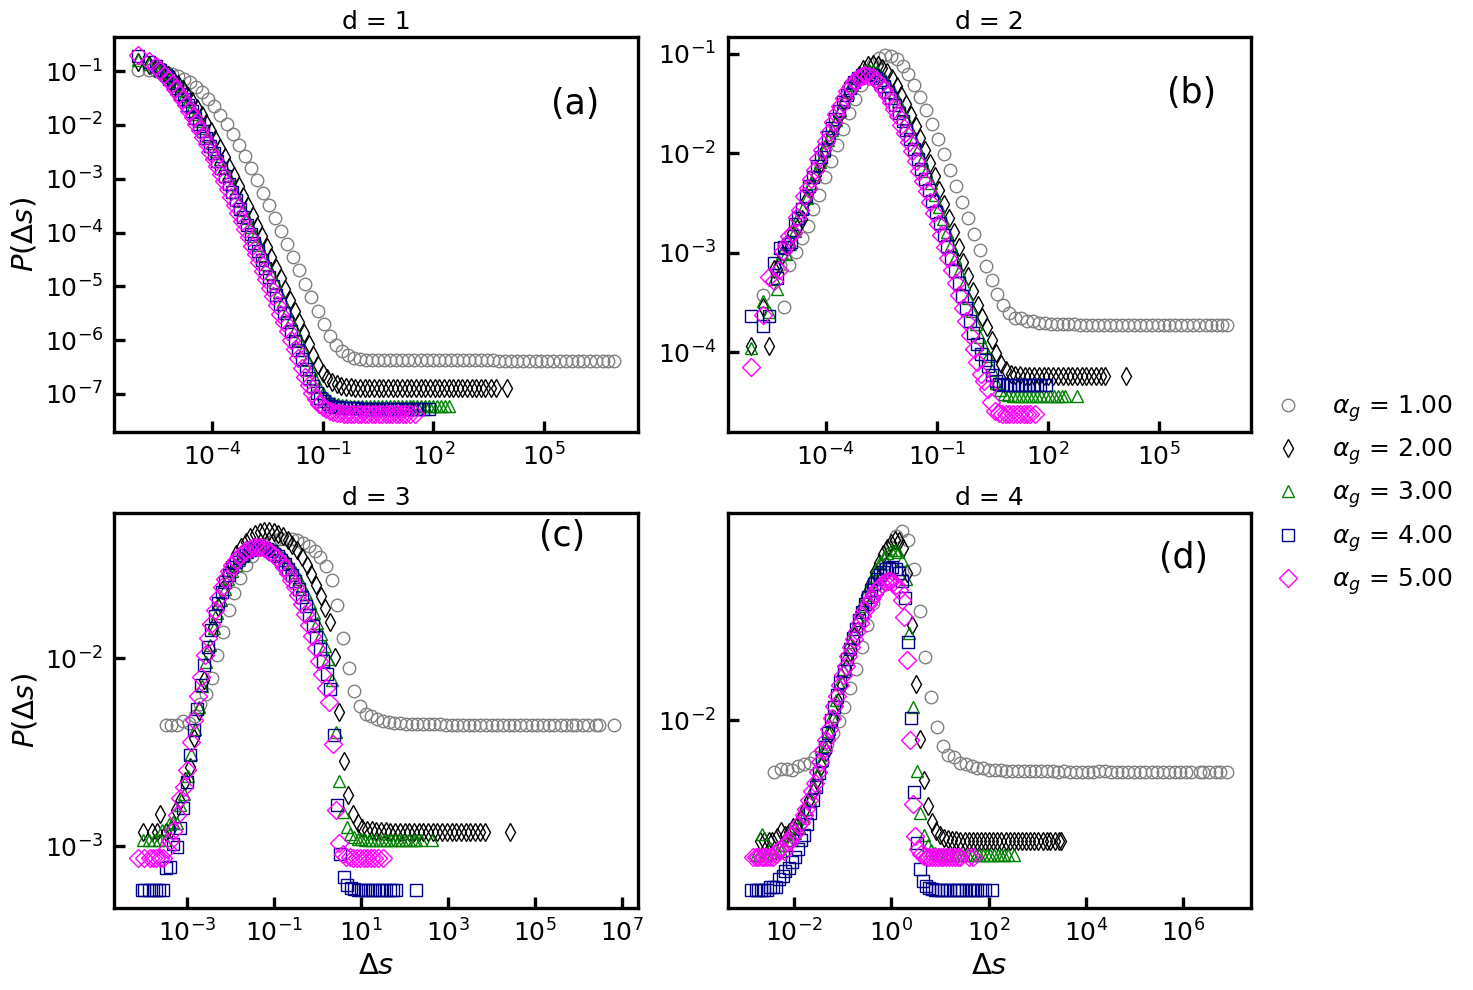

In [ ]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]
markers = ["o","d","^","s","D"]
#markers = ["o","o","o","o","o"]
labels_global = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]
markersize = 9
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
     # Plot data
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i],markers[i])
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i],markers[i])
    ax[1, 0].plot(k_3d_g[i], pk_3d_g[i],markers[i])
    ax[1, 1].plot(k_4d_g[i], pk_4d_g[i],markers[i])

thickness_axes =  2.4
parts_of_graphic = ['top', 'bottom', 'left', 'right']
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_g_v))]
# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False)

for f, d in zip(ax.flatten(), dim):
    f.set_title(f"$d = {d}$")

ax[0, 0].text(10**(5.2), 10**(-1.8), "$(a)$", style="normal" ,fontsize=25)
ax[0, 1].text(10**(5.2), 10**(-1.5), "$(b)$", style="normal" ,fontsize=25)
ax[1, 0].text(10**5.1, 10**(-1.4), "$(c)$", style="normal" ,fontsize=25)
ax[1, 1].text(10**5.5, 10**(-1.3), "$(d)$", style="normal" ,fontsize=25)


# ax[0, 0].text(10**(5.2), 10**(-2.0), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
# ax[0, 1].text(10**(5.2), 10**(-1.5), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
# ax[1, 0].text(10**(5.1), 10**(-1.4), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
# ax[1, 1].text(10**(5.5), 10**(-1.3), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})

for i in range(2):
    for j in range(2):
        #ax[i, j].set_xlim([1,10**4])
        #ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$")
        ax[1, j].set_xlabel(r"$\Delta s$")
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_g_N100000.pdf")
plt.show()

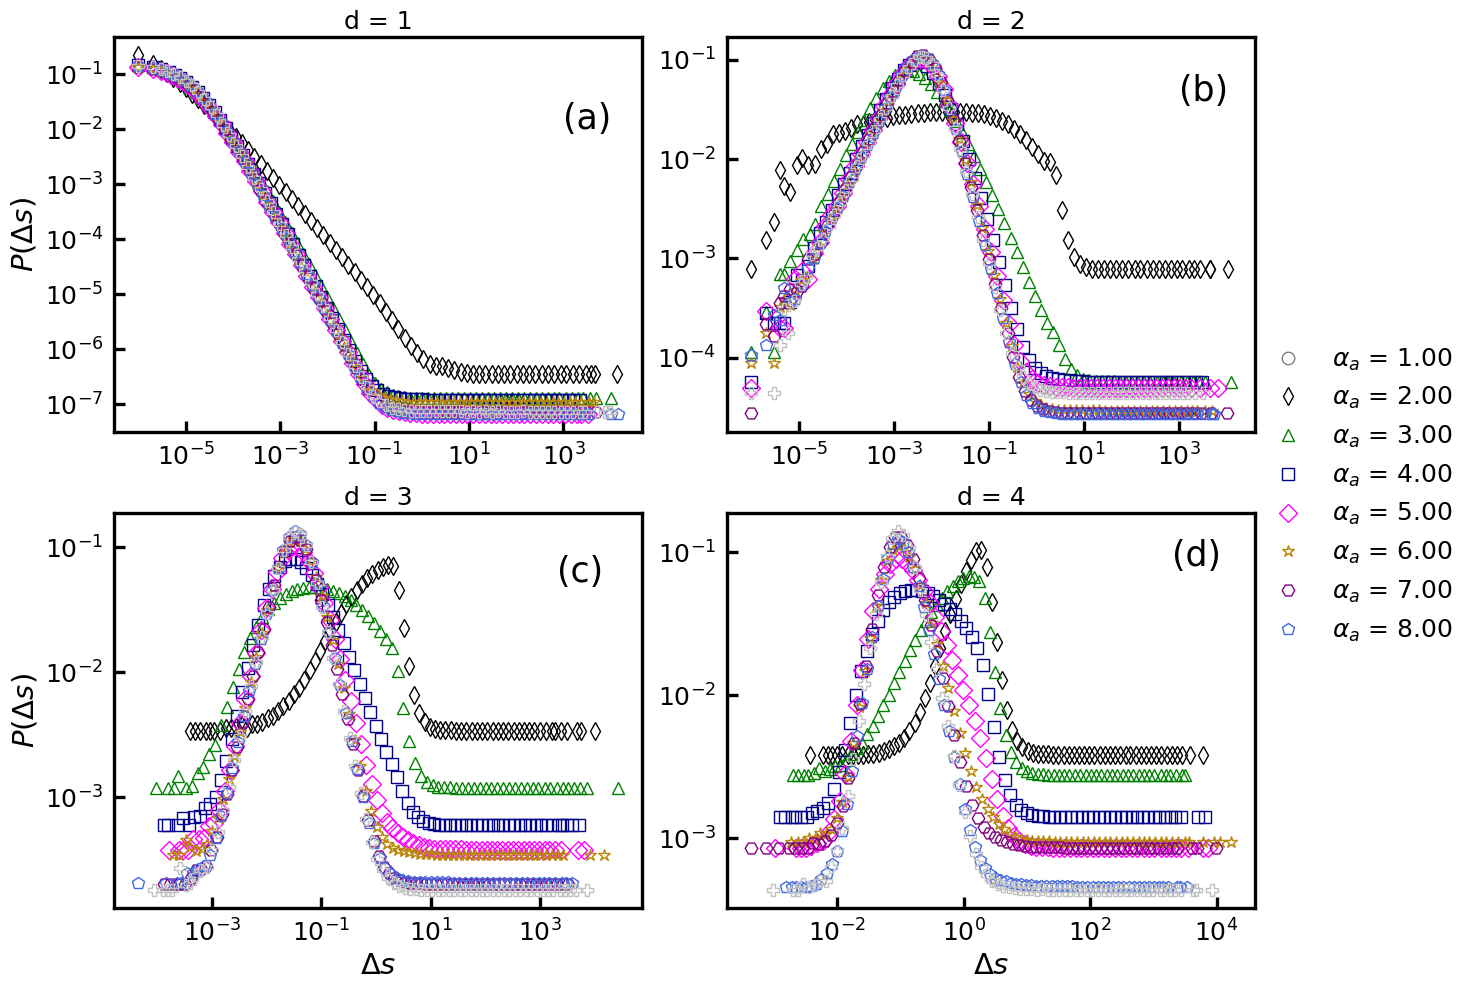

In [ ]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod","purple","royalblue", "silver"]

markers = ["o","d","^","s","D","*","H","p","P"]
labels_global = [rf"$\alpha_a = {alpha_a_v[i]:.2f}$" for i in range(1, len(alpha_a_v))]
#markers = ["o","o","o","o","o"]
labels_1 = [rf"$\alpha_a = {alpha_a_v[i]:.2f}$" for i in range(1,len(alpha_a_v))]
markersize = 9
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(1,len(alpha_a_v)):
     # Plot data
    ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i])
    ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i])
    ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i])
    ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i])

thickness_axes =  2.4
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_a_v))]
# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False)

ax[0, 0].text(10**(3), 10**(-2.0), "$(a)$", style="normal" ,fontsize=25)
ax[0, 1].text(10**(3), 10**(-1.41), "$(b)$", style="normal" ,fontsize=25)
ax[1, 0].text(10**3.3, 10**(-1.28), "$(c)$", style="normal" ,fontsize=25)
ax[1, 1].text(10**3.3, 10**(-1.10), "$(d)$", style="normal" ,fontsize=25)

# ax[0, 0].text(10**(2.8), 10**(-2.0), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
# ax[0, 1].text(10**(2.8), 10**(-1.41), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
# ax[1, 0].text(10**(3.2), 10**(-1.28), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
# ax[1, 1].text(10**(3.2), 10**(-1.10), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})

for f, d in zip(ax.flatten(), dim):
    f.set_title(f"$d = {d}$", fontsize=18)

parts_of_graphic = ['top', 'bottom', 'left', 'right']
for i in range(2):
    for j in range(2):
        #ax[i, j].set_xlim([1,10**4])
        #ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$")
        ax[1, j].set_xlabel(r"$\Delta s$")
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_a_N100000.pdf")
plt.show()